# 課題：ダイレクトインデックスの構築方法について
## 背景
* ダイレクトインデックス（Direct indexing）:インペックス投資の一種で、指数に連動する金融商品を保有するのではなくインデックスに連動するように金融商品を直接保有する手法
* 投資家は保有する銘柄を指定でき、特定のテーマの資産を保有する/しないといったニーズを満たすことができる
* インデックス投資 … S&P500等の指数に連動する金融商品を購入
　　　　　　　　　　　　　〇手数料、少額投資、市場リターン　×カスタマイズ、減税
* ラップ口座 … 個別資産を直接保有するが運用は証券会社が行う
　　　　　　　　　　　　　〇カスタマイズ、減税　×手数料、少額投資

<br> 
<br> 
<br> 

## 目的：ダイレクトインデックスのポートフォリオの構築方法について検討する
* 指数に連動するポートフォリオを構築するためには、指数を構成する銘柄を指数の計算方法に基づいた配分で購入すればいいが、構成銘柄数が多すぎる指数については効率面から現実的ではない。
* すべての銘柄ではなく顧客が指定した銘柄でトラッキングエラーを最小化する必要がある。

<br> 
<br> 
<br> 

## 検証１：銘柄数を指定した場合のポートフォリオ構築方法
* 対象指数：S&P500
* 対象銘柄：指数を構成する500銘柄の内時価総額上位50銘柄


In [1]:
import numpy as np
import scipy.stats as st
import cvxpy as cvx
import pandas as pd
import datetime

In [2]:
tickers=pd.read_csv('tickers.csv')
tickers=tickers['ticker'].to_list()
data = pd.read_csv('./data/'+tickers[0]+'.csv')
data = data.drop(['Open', 'High','Low','Close','Adj Close','Volume'], axis=1)
for ticker in tickers:
    d = pd.read_csv('./data/'+ticker+'.csv')
    d = d.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
    d = d.rename(columns={'Close': ticker})
    data = pd.merge(data,d,on='Date')

In [3]:
cal = data[['Date']]
cal['Datetime'] = pd.to_datetime(cal['Date'])
cal['year'] = cal['Datetime'].dt.year
cal['month'] = cal['Datetime'].dt.month
cal['week'] = cal['Datetime'].dt.week

/tmp/ipykernel_155/3635024390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal['Datetime'] = pd.to_datetime(cal['Date'])
/tmp/ipykernel_155/3635024390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal['year'] = cal['Datetime'].dt.year
/tmp/ipykernel_155/3635024390.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [4]:
cal['mon'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,3] != cal.iloc[index-1,3]:
        cal.iloc[index,5] = cal.iloc[index-1,5]+1
    else:
        cal.iloc[index,5] = cal.iloc[index-1,5]

/tmp/ipykernel_155/501106492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal['mon'] = 1


In [5]:
data = data.set_index('Date')

In [6]:
R = data.pct_change()
R = R.fillna(0)
R = R + 1
R = R.cumprod()

In [7]:
Benchmark = pd.read_csv('sp500.csv')
Benchmark = Benchmark.set_index('Date')
Benchmark = Benchmark.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
Benchmark = Benchmark.pct_change()
Benchmark = Benchmark.fillna(0)
Benchmark = Benchmark + 1
Benchmark = Benchmark.cumprod()

In [8]:
T = R.shape[0]
N = R.shape[1]


In [9]:
di = pd.DataFrame(index=Benchmark.index,columns=['Close'])
dw = pd.DataFrame(index=R.index,columns=R.columns)

In [21]:
mon_window = 36
weight = cvx.Variable(N)
for i in range(120 - mon_window):
    start = i+1
    end = i+mon_window
    startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].min()
    enddate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].max()
    asset = R[startdate:enddate].values
    indx = Benchmark[startdate:enddate].values
    indx = np.squeeze(indx)
    obj = cvx.Minimize(cvx.sum_squares(asset@weight - indx))
    mintracerr = cvx.Problem(obj, [cvx.sum(weight) == 1.0,weight >= 0])
    mintracerr.solve(verbose=False)
    w = weight.value
    w[w<0]=0
    w=w/w.sum()
    wt = np.expand_dims(w, 0)
    dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
    dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
    d = R[dstart:dend].values@w
    d = np.expand_dims(d, 1)
    di[dstart:dend]=d
    dw[dstart:dstart]=wt

In [22]:
dw = dw.dropna()

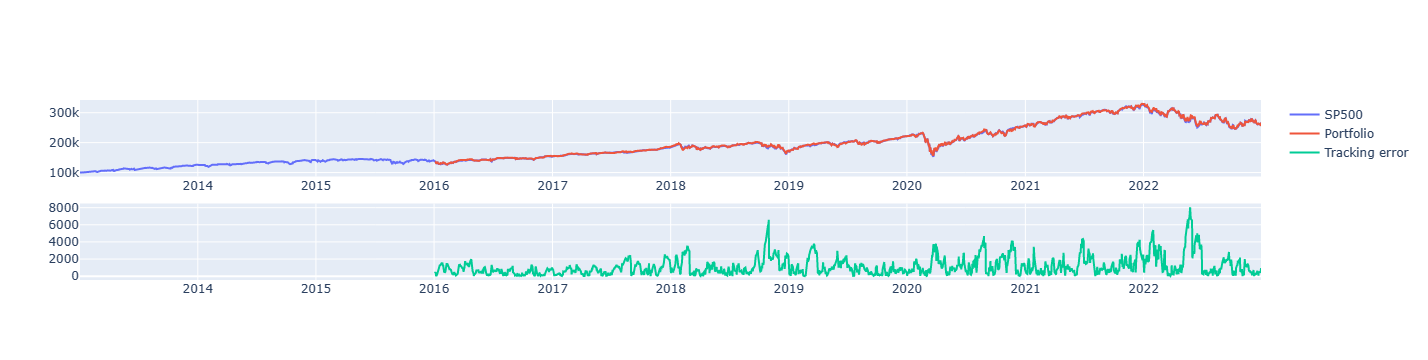

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
ganpon=100000
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=Benchmark['Close']*ganpon,
                         mode='lines',
                         name='SP500',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=di.index,
                         y=di['Close']*ganpon,
                         mode='lines',
                         name='Portfolio',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=((Benchmark['Close']*ganpon-di['Close']*ganpon)**2)**0.5,
                         mode='lines',
                         name='Tracking error',
                        ), row=2, col=1
              )
fig.show()

In [27]:
Benchmark.to_csv('b.csv')
di.to_csv('d.csv')